In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from isrobust_TFG.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent
data_path = project_path.joinpath("data")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

2024-12-27 18:58:32.369525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dotenv.dotenv_values()

stop = float(config["FRAC_STOP"])
start = float(config["FRAC_START"])
step = float(config["FRAC_STEP"])

In [3]:
frac_list = np.arange(start, stop, step)

In [4]:
results_path = Path(config["RESULTS_FOLDER"]).resolve()
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

In [5]:
results_path

PosixPath('/home/carlos/github/robustness_informed_TFM/results')

In [6]:
models = ["ivae_kegg", "ivae_reactome"] + [
    f"ivae_random-{frac:.2f}" for frac in frac_list
]
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.05',
 'ivae_random-0.15',
 'ivae_random-0.25',
 'ivae_random-0.35',
 'ivae_random-0.45']

In [7]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
metric_scores = metric_scores
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,6.702028,ivae_kegg
1,0,mse,train,0.000267,ivae_kegg
2,0,loss,val,6.675733,ivae_kegg
3,0,mse,val,0.000267,ivae_kegg
4,0,loss,test,6.711612,ivae_kegg


In [8]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model
0,train,1,0.618314,ivae_kegg
1,train,1,0.645411,ivae_kegg
2,train,1,0.636697,ivae_kegg
3,train,1,0.612017,ivae_kegg
4,train,1,0.686459,ivae_kegg


In [9]:
clustering_scores.groupby(["model", "layer"]).size()

model             layer
ivae_kegg         1        33
                  2        33
ivae_random-0.05  1        33
ivae_random-0.15  1        33
ivae_random-0.25  1        33
ivae_random-0.35  1        33
ivae_random-0.45  1        33
ivae_reactome     1        33
dtype: int64

In [10]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model
0,train,1,0.781904,ivae_kegg
1,train,1,0.783307,ivae_kegg
2,train,1,0.774309,ivae_kegg
3,train,1,0.790341,ivae_kegg
4,train,1,0.785362,ivae_kegg


In [11]:
informed_scores.groupby(["model", "layer"]).size()

model             layer
ivae_kegg         1        165
                  2        165
ivae_random-0.05  1        165
ivae_random-0.15  1        165
ivae_random-0.25  1        165
ivae_random-0.35  1        165
ivae_random-0.45  1        165
ivae_reactome     1        165
dtype: int64

In [12]:
clustering_scores["kind"] = "clustering"
informed_scores["kind"] = "informed"

In [13]:
(metric_scores
 .query("metric=='mse'")
 .drop(["seed"], axis=1)
 .groupby(["model", "metric", "split"])["score"]
 .describe()
 .drop(["count", "min", "max"], axis=1)
 .to_latex(
   "mse.tex",
    bold_rows=True,
    escape=True,
))

In [14]:
metric_scores_to_plot = metric_scores.copy().query("split=='test'").query("metric=='mse'").rename(columns={"model": "Modelo", "score":"Valor"})
metric_scores_to_plot["Valor"] = -np.log(metric_scores_to_plot["Valor"])

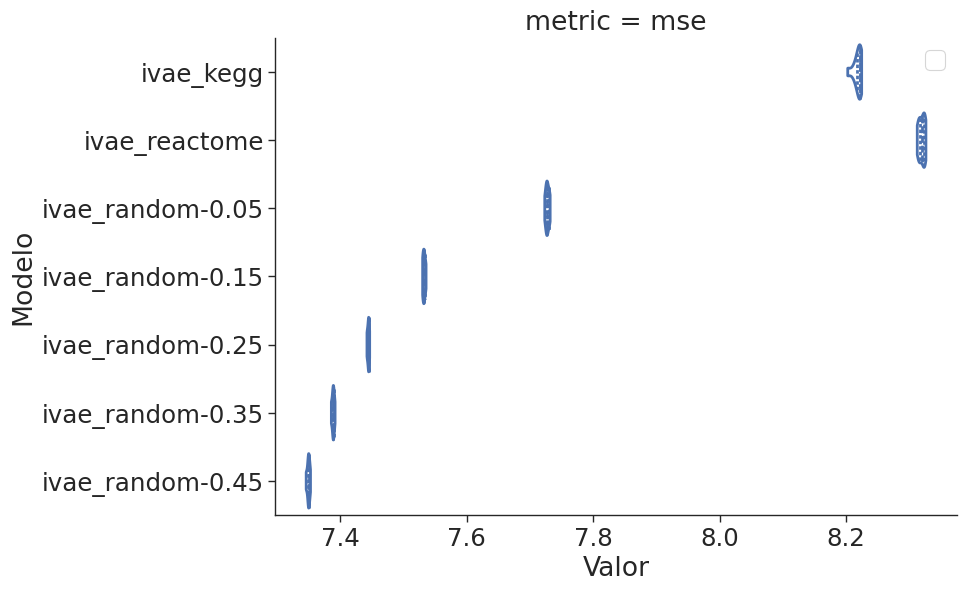

In [15]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=metric_scores_to_plot,
    kind="violin",
    col="metric",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="Modelo",
    x="Valor",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

g.savefig("model_mse.pdf")

In [16]:
scores = (
    pd.concat((clustering_scores, informed_scores), axis=0, ignore_index=True)
    .query("split=='test'")
    .query("layer <= 2")
    .drop(["split"], axis=1)
    .rename(columns={"kind": "metric"})
)

scores.head()

,layer,score,model,metric
22,1,0.610408,ivae_kegg,clustering
23,1,0.643938,ivae_kegg,clustering
24,1,0.643614,ivae_kegg,clustering
25,1,0.615501,ivae_kegg,clustering
26,1,0.702797,ivae_kegg,clustering


In [17]:
scores_to_plot = scores.copy()
scores_to_plot["layer_name"] = "Pathways"

scores_to_plot = scores_to_plot.replace("clustering", "AMI")
scores_to_plot = scores_to_plot.replace("informed", r"$\tau$")

mask = (scores_to_plot["layer"] == 1) & (scores_to_plot["model"] == "ivae_kegg")
scores_to_plot.loc[mask, "layer_name"] = "Circuitos"

mask = (scores_to_plot["layer"] == 1) & (scores_to_plot["model"] == "ivae_random")
scores_to_plot.loc[mask, "layer_name"] = "RndInf"

scores_to_plot["Modelo"] = scores_to_plot["model"] + " (" + scores_to_plot["layer_name"] + ")"

scores_to_plot = scores_to_plot.rename(columns={"score": "Valor", "metric": "Métrica"})
scores_to_plot.head()

,layer,Valor,model,Métrica,layer_name,Modelo
22,1,0.610408,ivae_kegg,AMI,Circuitos,ivae_kegg (Circuitos)
23,1,0.643938,ivae_kegg,AMI,Circuitos,ivae_kegg (Circuitos)
24,1,0.643614,ivae_kegg,AMI,Circuitos,ivae_kegg (Circuitos)
25,1,0.615501,ivae_kegg,AMI,Circuitos,ivae_kegg (Circuitos)
26,1,0.702797,ivae_kegg,AMI,Circuitos,ivae_kegg (Circuitos)


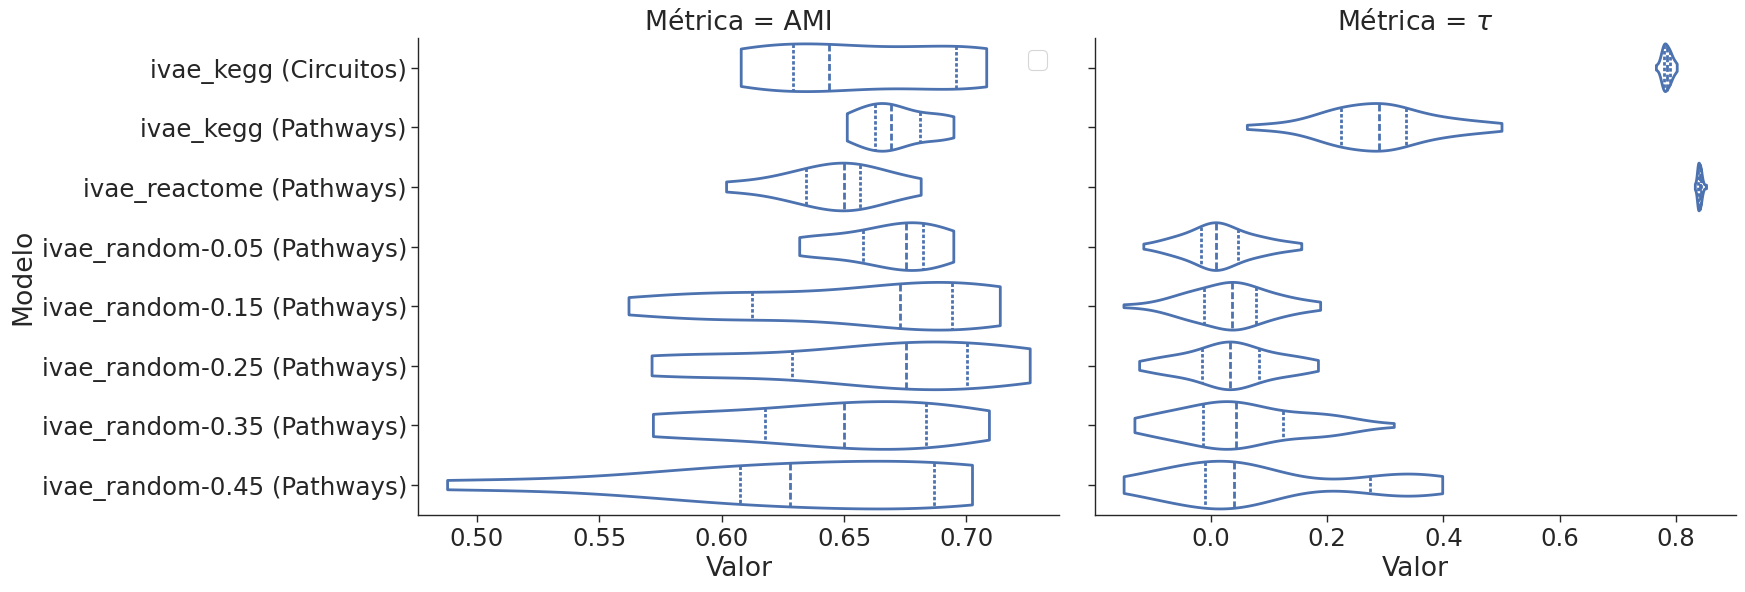

In [18]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=scores_to_plot,
    kind="violin",
    col="Métrica",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="Modelo",
    x="Valor",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

g.savefig("layer_scores.pdf")

In [19]:
def print_scores(df, fname):
  df_to_print = df.copy().query("layer <= 2")

  df_to_print["Capa"] = "Pathways"

  mask = (df_to_print["layer"] == 1) & (df_to_print["model"] == "ivae_kegg")
  df_to_print.loc[mask, "Capa"] = "Circuitos"

  mask = (df_to_print["layer"] == 1) & (df_to_print["model"] == "ivae_random")
  df_to_print.loc[mask, "Capa"] = "RndInf"

  (df_to_print
  .rename(columns={"model": "Modelo", "split": "Partición"})
  .groupby(["Modelo", "Capa", "Partición"])["score"]
  .describe().drop(["count", "min", "max"], axis=1)
  .to_latex(
      fname,
      bold_rows=True,
      escape=True,
  ))

In [20]:
print_scores(informed_scores, "informed.tex")
print_scores(clustering_scores, "clustering.tex")
